In [1]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all='print')
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
df = pd.read_csv('../data/fifa.csv', index_col=0)
df.shape

(18207, 88)

In [3]:
def convert_str_value_to_numeric(str_value):
    if str_value in ['NaN', 'nan', np.nan]:
        return np.nan
    else:
        if str_value.endswith('K'):
            multiplier = 1
        elif str_value.endswith('M'):
            multiplier = 1000
        else:
            multiplier = 1
        
        re_pattern = re.compile('[^0-9\.\-]')
        return float(re.sub(re_pattern, '', str_value)) * multiplier

In [4]:
df['Value'] = df['Value'].apply(convert_str_value_to_numeric)
df['Wage'] = df['Wage'].apply(convert_str_value_to_numeric)

## Exercise: Predict player's value from skills

#### 1. Let's filter data by Value >= $50k. Also Lets add a column that represents the log of Value column. Lets plot a boxplots of the log_Values for different Ages - what can you tell about the relationship between Value and Age of a player?

In [5]:
data_df = df[df['Value'] >= 50].copy()
data_df['log_Value'] = np.log(data_df['Value'])

In [6]:
data_df.shape

(17831, 89)

- As intuitively expected, the value of players generally peak at age of 23 - 31. For older age groups or much younger age groups, the value generally decreases.
- One sensible choice to make use of this observation would be to group ages to different categories - such as 'young', 'mid', 'old'
- It is important to visualize to get a sense of the relationship between the predictor and response. In this case, in the context of linear models it would be incorrect to use Age in its raw form as a predictor since the relationship with the response variable is not monotonic

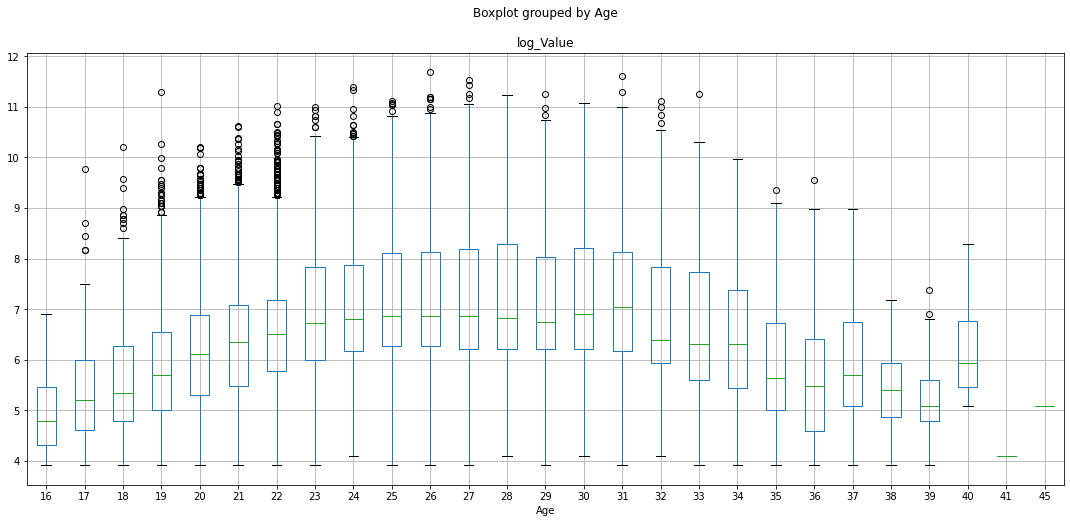

In [7]:
fig, ax = plt.subplots(figsize=(18,8))
data_df.boxplot(column='log_Value', by='Age', ax=ax)

#### 2. Let’s create a categorical variable (which we will refer to as ‘age_cat’ that splits Age to 3 categories – 22 and under / 23 – 31 / 32 and over. Let’s regress ‘log_Value’ on ‘age_cat’ and show the coefficients. Can we say that the addition of the ‘age_cat’ variables is statistically significant? (hint: ANOVA F-stat)

In [8]:
age_cat = pd.cut(data_df['Age'],  [0, 22, 31, 50],)

In [9]:
age_cat = pd.cut(data_df['Age'],  [0, 22, 31, 50],)
data_df['age_cat'] = age_cat
data_df[['Age', 'age_cat']].head()

,Age,age_cat
0,31,"(22, 31]"
1,33,"(31, 50]"
2,26,"(22, 31]"
3,27,"(22, 31]"
4,27,"(22, 31]"


In [10]:
lm2 = smf.ols('log_Value ~ C(age_cat)', data=data_df).fit()
lm2.params

Intercept                                         6.184858
C(age_cat)[T.Interval(22, 31, closed='right')]    0.926933
C(age_cat)[T.Interval(31, 50, closed='right')]    0.284385
dtype: float64

In [11]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Value   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     978.9
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:29:33   Log-Likelihood:                -30143.
No. Observations:               17831   AIC:                         6.029e+04
Df Residuals:                   17828   BIC:                         6.031e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          6.1849      0.017    365.280      0.000       6.152       6.218
C(age_cat)[T.Interval(22, 31, closed='right')]     0.9269      0.021     43.322      0.000       0.885       0.969
C(age_cat)[T.Interval(31, 50, closed='right')]     0.2844      0.036      8.005      0.000       0.215       0.354
==============================================================================
Omnibus:                      741.975   Durbin-Watson:                   0.420
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.787
Skew:                           0.530   Prob(JB):                    1.19e-182
Kurtosis:                       2.946   Cond. No.                         4.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Intercept: the mean log value of the age group of 22 and under
- beta1: the additional mean log value of the age group of 23 - 31 over the 22 and under age group / it's intuitive that this beta1 is relatively large compared to beta2
- beta2: the additional mean log value of the age group of 32 and over over the 22 and under age group
- Yes, the F-stat is provided in the summary (p-value for F-stat is 0)

#### 3. In addition to the previous model's predictors let's add 'Finishing' and 'BallControl' as additional predictors and again fit OLS. Do you see anything unintuitive about the coefficient on 'Finishing'?

- Result of OLS shown below
- It is unintuitive that we see a negative coefficient assigned to the Finishing skill (so with all other variables constant, the model says that as 'Finishing' skill increases, the log value would decrease. There could be several different causes of this:
    - Finishing skill matters for specific types of players - particularly the attackers -> we will create interaction features in the next question (domain knowledge would be important here)
    - Finishing skill may be highly correlated with other features in the regression. Therefore, when we look at the relationship between log value vs. Finishing skill, with the effects from the other features taken out (from the log value and from the Finishing skill), the residual relationship might be negatively correlated.
    - Coefficient is not statistically significant (due to issues such as multi-collinearity)

In [12]:
lm3 = smf.ols('log_Value ~ C(age_cat) + BallControl + Finishing', data=data_df).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Value   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     2092.
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:29:33   Log-Likelihood:                -27570.
No. Observations:               17783   AIC:                         5.515e+04
Df Residuals:                   17778   BIC:                         5.519e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          3.9731      0.033    120.095      0.000       3.908       4.038
C(age_cat)[T.Interval(22, 31, closed='right')]     0.7159      0.019     37.998      0.000       0.679       0.753
C(age_cat)[T.Interval(31, 50, closed='right')]     0.2001      0.031      6.466      0.000       0.139       0.261
BallControl                                        0.0410      0.001     48.789      0.000       0.039       0.043
Finishing                                         -0.0013      0.001     -1.828      0.068      -0.003    9.37e-05
==============================================================================
Omnibus:                     1273.082   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1583.298
Skew:                           0.681   Prob(JB):                         0.00
Kurtosis:                       3.529   Cond. No.                         327.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 4. Perhaps the Finishing skill has more meaning if the player is in attacking position. Let's add another categorical variable called 'attacking_pos' and assign a value of 1 if position is in [ST/CF/RF/LF/CAM/RAM/LAM] and 0 otherwise

In [13]:
attacking_positions = [
    'ST', 
    'CF', 
    'RF', 
    'LF', 
    'CAM',
    'RAM', 
    'LAM'
]

data_df['attacking_pos'] = data_df['Position'].isin(attacking_positions).astype(int)

#### Let's reuse the previous OLS relationship. But in addition to the 'Finishing' predictor let's also add the 'attacking_pos' cateogorical variable and the interaction term between 'attacking_pos' and 'Finishing'. Please show the coefficients. Also, what are the meanings of these added coefficients?

- attacking_pos coefficient: the additional log value amount of player in attacking position vs. non attacking position (when all other variables stay constant)
- Finishing coefficient: the increase in log value as finishing skill increases for a non-attacking player
- attacking_pos:Finishing coefficient: the additional increase (additional to the 'Finishing' coefficient above) in log value as finishing skill increases for an attacking player

In [14]:
## Note: 
# The formula 
#  'log_Value ~ I(age_cat) + BallControl + attacking_pos * Finishing' 
# is equivalent to
#  'log_Value ~ C(age_cat) + BallControl + attacking_pos + Finishing + attacking_pos : Finishing' 
#
# If we just want to add the interaction between attacking_pos and Finishing, we can use
#    'log_Value ~ C(age_cat) + BallControl + I(attacking_pos * Finishing)'
# OR 'log_Value ~ C(age_cat) + BallControl + attacking_pos : Finishing'
## 

lm4 = smf.ols('log_Value ~ C(age_cat) + BallControl + \
              attacking_pos * Finishing', data=data_df).fit()
lm4.params

Intercept                                         4.137119
C(age_cat)[T.Interval(22, 31, closed='right')]    0.606267
C(age_cat)[T.Interval(31, 50, closed='right')]    0.065817
BallControl                                       0.041535
attacking_pos                                    -5.514533
Finishing                                        -0.003553
attacking_pos:Finishing                           0.084155
dtype: float64

### Appendix A

- ANOVA? F-stat?

Let's revisit model 2 (lm2) - are the coefficients significant? (ie) Can we reject the null hypothesis that beta_0 = beta_1 = ... = beta_p = 0? vs. alternative that at least one is significantly non-zero?

F-stat = (variance explained by model) / (unexplained variance)

If this value is large enough, then we can say that the coefficients are significant (reject the null)

In [15]:
from scipy.stats import f

In [16]:
y_vals_2 = lm2.model.endog

n_2 = y_vals_2.shape[0]
p_2 = lm2.model.exog.shape[1] # number of independent features (including intercept)

In [17]:
df_model_2 = p_2 - 1
df_resid_2 = n_2 - p_2

In [18]:
# residual sum of squares
rss_2 = (lm2.resid ** 2).sum()
var_unexplained_2 = rss_2 / df_resid_2

In [19]:
tss_2 = ((y_vals_2 - y_vals_2.mean()) ** 2).sum()
ess_2 = tss_2 - rss_2
var_explained_2 = ess_2 / df_model_2

F-stat follows an f-distribution, hence the calculated p value below

In [20]:
f_stat_2 = var_explained_2 / var_unexplained_2
p_value_2 = 1 - f.cdf(f_stat_2, dfn=df_model_2, dfd=df_resid_2)

Just sanity check vs. statsmodels api

In [21]:
f_stat_2, p_value_2

(978.9012651039043, 1.1102230246251565e-16)

In [22]:
lm2.fvalue, lm2.f_pvalue

(978.9012651039067, 0.0)

Now lets look at model 4 (lm4) - can we say that the additional variables (compared to model 2) are statistically significant? Similar to above but slight variant

This time, F-stat = (additional explained variance from larger model) / (unexplained variance of larger model)

In [23]:
y_vals_4 = lm4.model.endog

n_4 = y_vals_4.shape[0]
p_4 = lm4.model.exog.shape[1] # number of independent features (including intercept)

In [24]:
df_model_4 = p_4 - 1
df_resid_4 = n_4 - p_4

In [25]:
# residual sum of squares
rss_4 = (lm4.resid ** 2).sum()

In [26]:
var_unexplained_4 = rss_4 / df_resid_4

In [27]:
df_numerator = p_4 - p_2

In [28]:
additional_var_explained_4 = (rss_2 - rss_4) / df_numerator

In [29]:
f_stat_4 = additional_var_explained_4 / var_unexplained_4

In [30]:
f_stat_4
p_value_4 = 1 - f.cdf(f_stat_4, dfn=df_numerator, dfd=df_resid_4)

In [31]:
f_stat_4, p_value_4

(1919.4538228401093, 1.1102230246251565e-16)

In [32]:
sm.stats.anova_lm(lm2, lm4,)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,17828.0,30691.892785,0.0,NaN,NaN,NaN
1,17776.0,21434.078935,52.0,9257.81385,147.650294,0.0


### Appendix B

Empirical proof of multivariate coefficient being equivalent to univariate with effect of all other variables stripped out

In [33]:
wanted_columns = [
    'log_Value',
    'BallControl',
    'attacking_pos',
    'Finishing',
]
append_b_df = data_df.dropna(subset=wanted_columns, how='any')
append_b_df.shape

(17783, 91)

In [34]:
multi_lm = smf.ols('log_Value ~ BallControl + attacking_pos + Finishing + attacking_pos:Finishing', data=append_b_df).fit()

In [35]:
multi_lm.params

Intercept                  4.345669
BallControl                0.043712
attacking_pos             -6.170384
Finishing                 -0.003086
attacking_pos:Finishing    0.093583
dtype: float64

Lets focus on the coefficient on 'BallControl'

In [36]:
lm_ballcontrol_vs_rest = smf.ols('BallControl ~ attacking_pos + Finishing + attacking_pos:Finishing', data=append_b_df).fit()

In [37]:
# This residual represents ballcontrol variable with effects of all other variables stripped out
ballcontrol_resid = lm_ballcontrol_vs_rest.resid

In [38]:
ballcontrol_resid.shape

(17783,)

In [39]:
uni_lm = smf.ols('log_Value ~ ball_control_resid - 1', data={'log_Value': append_b_df['log_Value'], 'ball_control_resid': ballcontrol_resid}).fit()

In [40]:
uni_lm.params

ball_control_resid    0.043712
dtype: float64